In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mod_models as mm
import mod_evolution as me
import mod_visualization as mv
import mod_stimulation as ms
from mod_models import logger
import inputools.Trajectory as it
from tqdm import tqdm
from tools.utils import clf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Settings

In [5]:
N = 4
Nj = 6

## Inputs

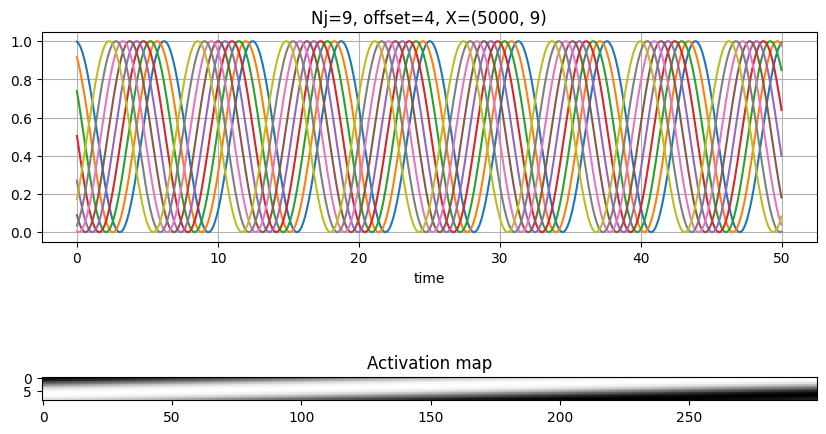

In [15]:
def make_input(T: int=50, dx: float=0.01, offset: int=4, Nj: int=6, plot=False):

    """
    Parameters
    ----------
    T : int
        duration
    dx :
        spatial unit
    offset : int
        range of the shift distribution
    plot : bool
    """
    
    layer = lambda x: (np.cos(x + np.linspace(1e-1, offset, Nj)) + 1) / 2
    
    Z = np.arange(0, T, dx).reshape(-1, 1)
    X = layer(Z)

    if plot:
        plt.figure(figsize=(10, 6))
        
        plt.subplot(211)
        for x in X.T:
            plt.plot(Z, x)
        plt.grid()
        plt.title(f"{Nj=}, {offset=}, X={X.shape}") 
        plt.xlabel("time")
        
        plt.subplot(212)
        plt.title("Activation map")
        plt.imshow(X[:300].T, cmap="Greys")
        plt.show()
        
    return X

_ = make_input(Nj=9, plot=True)

In [6]:
model = mm.RateNetwork3(N=N, Nj=Nj, 
                       gain=4,
                       bias=2,
                       lr=1,
                       lr_beta=1.,
                       rule='hebb',
                       wff_std=0.01,
                       wff_min=0.01,
                       wff_max=3.,
                       wff_const=7,
                       wff_tau=10,
                       loc_magnitude=2)
logger.info(model)

2023-11-22 18:36:58 | RateNetwork3(N=4, Nj=6, rule=hebb)


###### Load model from evolution

In [7]:
genome = me.load_best_individual()
genome

2023-11-22 23:56:31 | Available files in /Users/daniekru/Research/lab/PCNN/cache:
2023-11-22 23:56:31 | 0: best_2239_r3.json
2023-11-22 23:56:31 | 1: best_2220_r3.json
2023-11-22 23:56:31 | 2: best_2238_r3.json
2023-11-22 23:56:31 | 3: best_2233_r3.json
2023-11-22 23:56:31 | 4: best_2215_r3.json
2023-11-22 23:56:31 | 5: best_ind_2238.json
2023-11-22 23:56:31 | 6: best_2342_r3.json
2023-11-22 23:56:31 | 7: best_ind_2311.json
2023-11-22 23:56:31 | 8: top_ij_1.json
2023-11-22 23:56:31 | 9: best_2227_r3.json
2023-11-22 23:56:31 | 10: best_2218_r3.json
2023-11-22 23:56:31 | 11: best_2149_r3.json
2023-11-22 23:56:31 | 12: best_2226_r3.json
2023-11-22 23:56:31 | 13: best_2132_r3.json
2023-11-22 23:56:31 | 14: best_2129_r3.json
2023-11-22 23:56:31 | 15: best_2224_r3.json
2023-11-22 23:56:31 | 16: best_2213_r3.json


Choose a file:  6


2023-11-22 23:56:39 | Best individual loaded from best_2342_r3.json in /Users/daniekru/Research/lab/PCNN/cache.


{'gain': 20.0,
 'bias': 1.8,
 'lr': 0.29733,
 'tau': 50.0,
 'wff_std': 0.001,
 'wff_min': 0.0,
 'wff_max': 3.0,
 'wff_tau': 17,
 'rule': 'hebb',
 'std_tuning': 0.001,
 'soft_beta': 1.0,
 'dt': 0.053,
 'N': 8,
 'Nj': 6}

In [8]:
model = mm.RateNetwork2(**genome)
logger.info(model)

2023-11-22 23:56:47 | RateNetwork2(N=8, Nj=6, rule=hebb)


## Simulation

KeyboardInterrupt: 

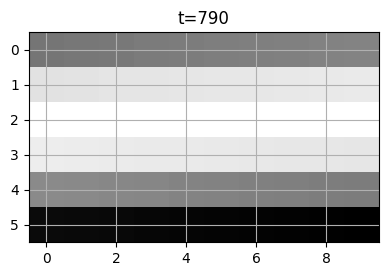

In [7]:
model.reset()


record = np.zeros((4, len(X)))
X2 = np.zeros((len(X) + 10, Nj))

for t, x in enumerate(X):
    
    model.step(x=x.reshape(-1, 1))
    record[0, t] = (model.Wff @ x.reshape(-1, 1))[0]
    record[1, t] = (model.Wff @ x.reshape(-1, 1))[1]
    record[2, t] = model.u[0]
    record[3, t] = model.u[1]
    X2[10:t+10] = X[:t]


    if t % 10 == 0:
        
        clf()
        plt.figure(figsize=(15, 6))
        plt.tight_layout()
        
        plt.subplot(221)
        plt.imshow(X2.T[:, t-10:t], cmap="Greys")
        #plt.ylim((0, 1))
        plt.title(f"{t=}")
        #plt.xlabel("time")
        plt.grid()
        
        plt.subplot(222)
        plt.axvline(0, color='black', alpha=0.3)
        plt.plot(np.flip(model.Wff[0], axis=0), range(Nj), '-b', alpha=0.4)
        plt.plot(np.flip(model.Wff[0], axis=0), range(Nj), 'ob', alpha=0.4)
        plt.plot(np.flip(model.Wff[1], axis=0), range(Nj), '-r', alpha=0.4)
        plt.plot(np.flip(model.Wff[1], axis=0), range(Nj), 'or', alpha=0.4)
        plt.title(f"Weights")
        plt.yticks(())
        plt.xlim((-5, 7))
        #plt.xlabel("intensity")
        plt.grid()
        
        plt.subplot(223)
        #plt.plot(range(t), record[0, :t])
        #plt.plot(range(t), record[1, :t])
        plt.imshow(model.Wff, cmap="plasma")
        plt.title("Input $W^{ff}$@$x$ : "+f"{record[0, t]:.3f}, {record[1, t]:.3f}")
        #plt.ylim((0, 20))
        plt.grid()
        
        plt.subplot(224)
        plt.plot(range(t), record[2, :t])
        plt.plot(range(t), record[3, :t])
        plt.title(f"$u$={np.around(model.u.T, 3)} - I={model.I_loc.T}")
        plt.ylim((0, 1.3))
        plt.grid()
        plt.pause(0.001)

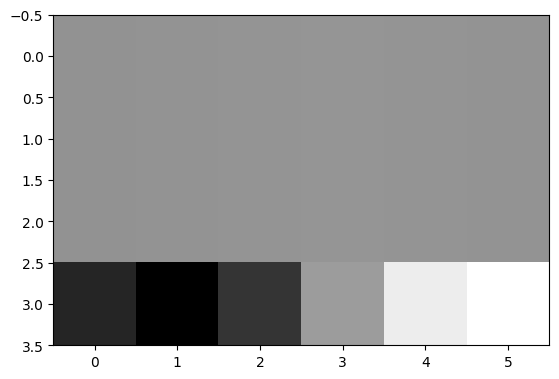

In [151]:
plt.imshow(model.Wff, cmap="Greys");

In [47]:
w = model.Wff
w

array([[0.05315329, 0.04514738, 0.03239973, 0.00884768, 0.01254714,
        0.01685206],
       [0.00659101, 0.00540898, 0.00144747, 0.00597474, 0.00416458,
        0.00205326]])

In [49]:
 w.max(axis=1) 

array([0.05315329, 0.00659101])

### Local stimulation

#### Supra-threshold

In [251]:
N = 5
T = 100

x = np.arange(N)
y = np.zeros((T, N))
for t in range(T):
    y[t, np.random.randint(0, N)] = 1

#### Sub-threshold

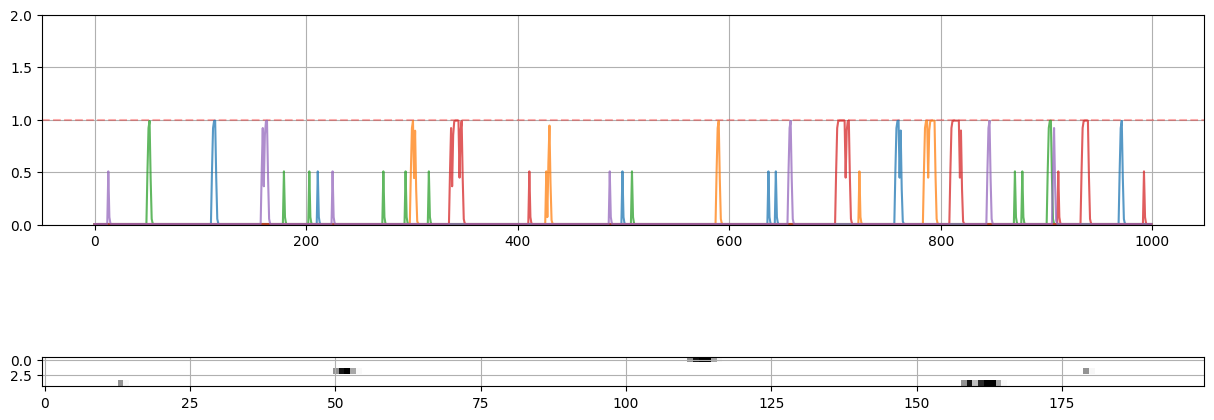

In [1057]:
def subthr(plot=True, noise=True):
    
    T = 1000
    N = 5
    thr = 1.
    u = np.ones((N, 1))*1e-8
    tau_0 = 30.
    tau = tau_0
    curr = np.zeros((N+1, 1))
    
    record = np.zeros((T, N))
    for t in range(T):
    
        p = np.array((u).flatten().tolist() + [1])
        p = p/p.sum()
        curr *= 0
        curr[np.random.choice(range(N+1), p=p, size=1)] = 1.
        u += (-u)/tau + int(noise)*np.random.normal(0., 0.1, (N, 1)) + curr[:-1]
    
        # activation
        u = 1 / (1 + np.exp(-5*(u - thr)))
    
        # adaptive threshold
        #tau += (1*u + tau_0*(1-u) - tau) / 2
        
        # record
        record[t, :] = u.flatten()
    
    if plot:
        plt.figure(figsize=(15, 6))
        plt.subplot(211)
        plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(T), record[:, i], alpha=0.75)
        
        plt.grid()
        plt.ylim((0, 2))

        plt.subplot(212)
        plt.imshow(record[:200].T, cmap='Greys')
        plt.grid()
        plt.show()

    return record

record = subthr(plot=True, noise=0)

**Analysis**

In [1058]:
nb = 100
sum1 = np.zeros((nb, 2))
for i in tqdm(range(nb)):
    rec = subthr(plot=False)
    rec = np.where(rec > 0.4, 1, 0)
    sum1[i] = [rec.sum(axis=1).mean(), 
               (np.exp(rec.sum(axis=0))/np.exp(rec.sum(axis=0)).sum()).std()]

print("With noise")
print(f"mean (over T): {sum1.mean(axis=0)[0]:.3f}")
print(f"std (over N): {sum1.mean(axis=0)[1]:.3f}")

100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.88it/s]

With noise
mean (over T): 0.075
std (over N): 0.367


In [1059]:
nb = 100
sum1 = np.zeros((nb, 2))
for i in tqdm(range(nb)):
    rec = subthr(plot=False, noise=False)
    rec = np.where(rec > 0.4, 1, 0)
    sum1[i] = [rec.sum(axis=1).mean(), 
               (np.exp(rec.sum(axis=0))/np.exp(rec.sum(axis=0)).sum()).std()]

print("Without noise")
print(f"mean (over T): {sum1.mean(axis=0)[0]:.3f}")
print(f"std (over N): {sum1.mean(axis=0)[1]:.3f}")

100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.97it/s]

Without noise
mean (over T): 0.070
std (over N): 0.364


In [724]:
sums = []
for i in range(N):
    sums += [np.where(record[:, i] > 0.99, 1, 0).sum()]
print('no noise ', sums, sum(sums))

no noise  [0, 0, 9, 7, 10] 26


In [735]:
sums = []
for i in range(N):
    sums += [np.where(record[:, i] > 0.99, 1, 0).sum()]
print('noise ', sums, sum(sums))

noise  [3, 9, 1, 0, 5] 18


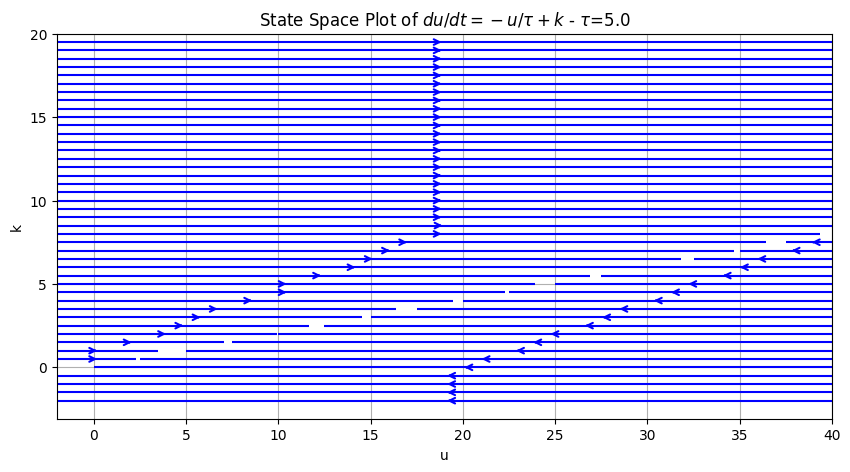

In [284]:
# Parameters
u_range = np.linspace(-2, 40, 40)
k_range = np.linspace(-2, 20, 30)

# Create a grid of u and k values
U, K = np.meshgrid(u_range, k_range)

# Time constant
tau = 5.0

# Define the ODE
dU_dt = -U/tau + K

# Plot
plt.figure(figsize=(10, 5))
plt.streamplot(U, K, dU_dt, np.zeros_like(dU_dt), density=1.5, arrowstyle='->', color='blue')
plt.xlabel('u')
plt.ylabel('k')
plt.title(f"State Space Plot of $du/dt = -u/\\tau + k$ - $\\tau$={tau}")
plt.grid(True)
plt.show()

#### Oscillatory

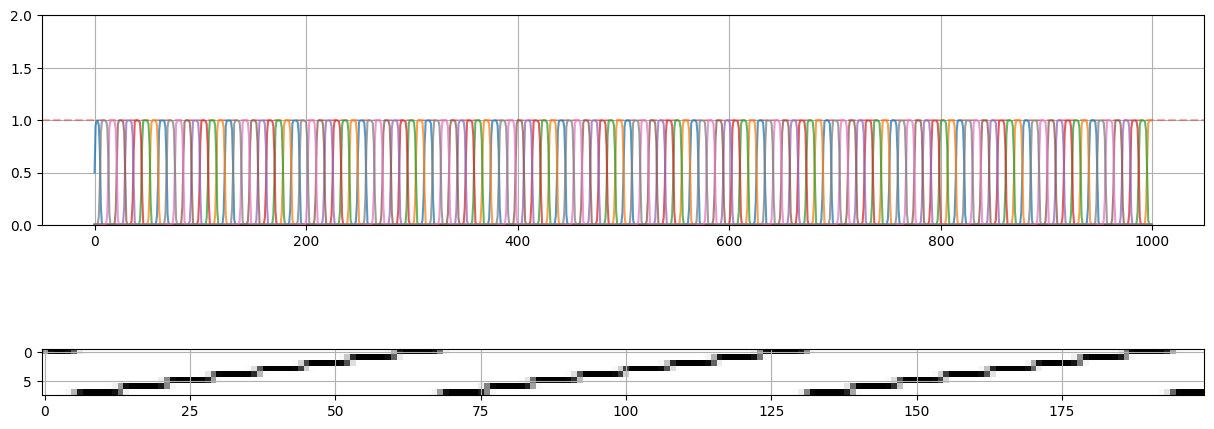

In [8]:
T = 1000
dt = 0.1
N = 8
tuning = np.linspace(0, 2*np.pi, N, endpoint=False).reshape(-1, 1)

thr = 1.
u = np.ones((N, 1))*1e-8
tau_0 = 30.
tau = tau_0
curr = np.zeros((N+1, 1))

record = np.zeros((T, N))
for t in range(T):

    u += (-u)/tau + np.exp(-(np.cos(t*dt + tuning) - 1)**2/0.01)

    # activation
    u = 1 / (1 + np.exp(-6*(u - thr)))

    # adaptive threshold
    #tau += (1*u + tau_0*(1-u) - tau) / 2
    
    # record
    record[t, :] = u.flatten()

plt.figure(figsize=(15, 6))
plt.subplot(211)
plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
for i in range(N):
    plt.plot(range(T), record[:, i], alpha=0.75)

plt.grid()
plt.ylim((0, 2))

plt.subplot(212)
plt.imshow(record[:200].T, cmap='Greys')
plt.grid()
plt.show()


#### + Lateral inhibition

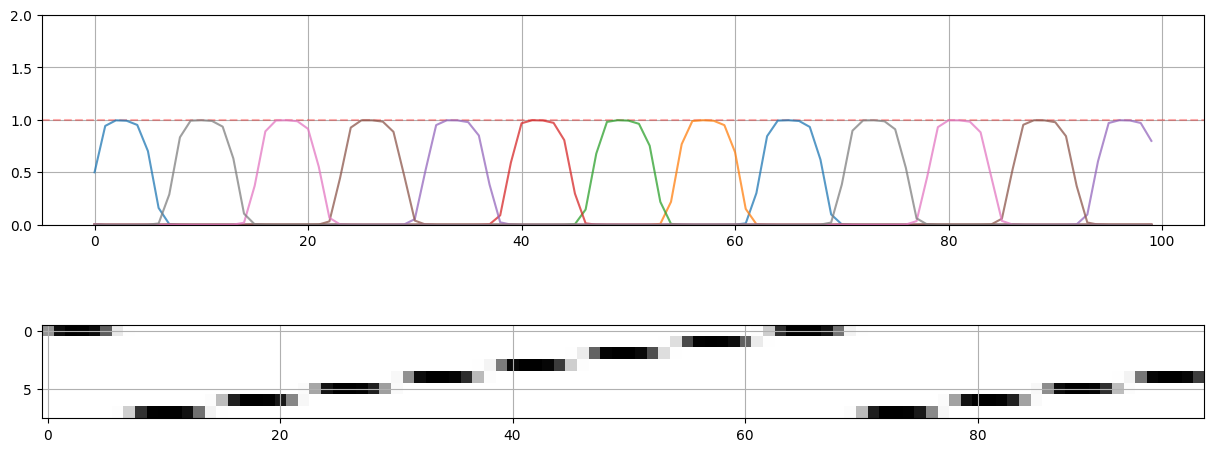

In [69]:
T = 100
dt = 0.1
N = 8
tuning = np.linspace(0, 2*np.pi, N, endpoint=False).reshape(-1, 1)

thr = 1.
u = np.ones((N, 1))*1e-8
tau_0 = 30.
tau = tau_0
curr = np.zeros((N+1, 1))

# lateral
Wr = -1  * (np.ones((N, N)) - np.eye(N))

record = np.zeros((T, N))
for t in range(T):

    u += (-u)/tau + np.exp(-(np.cos(t*dt + tuning) - 1)**2/0.01) + Wr @ u

    # activation
    u = 1 / (1 + np.exp(-6*(u - thr)))

    # adaptive threshold
    #tau += (1*u + tau_0*(1-u) - tau) / 2
    
    # record
    record[t, :] = u.flatten()

plt.figure(figsize=(15, 6))
plt.subplot(211)
plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
for i in range(N):
    plt.plot(range(T), record[:, i], alpha=0.75)

plt.grid()
plt.ylim((0, 2))

plt.subplot(212)
plt.imshow(record[:200].T, cmap='Greys')
plt.grid()
plt.show()


## Plasticity

#### Only plasticity

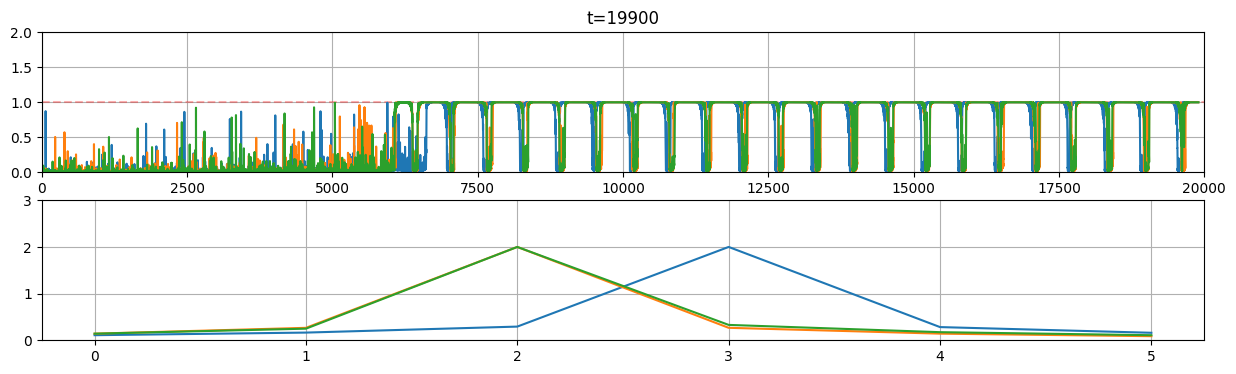

In [59]:
N = 3
T = len(X)

# neural settings
thr = 1.
u = np.ones((N, 1))*1e-8
W = np.ones((N, Nj))*1e-3
tau = 30.
lr = 0.01

# plasticity
rule = 'hebb'
beta = 10

# record
record = np.zeros((T, N))

for t, x in enumerate(X):
        
    u += (-u)/tau + W @ x.reshape(-1, 1) + np.random.normal(0, 0.3, size=(N, 1))**2
    
    # activation
    u = 1 / (1 + np.exp(-6*(u - thr)))

    # plasticity
    if rule == 'hebb':
        dw = u * x
    elif rule == 'oja':
        dw = u * x - W @ (x * x)

    W += lr * dw * (np.exp(beta*W)/np.exp(beta*W).sum(axis=1, keepdims=True))

    W = W.clip(1e-3, 2e0)

    # record
    record[t] = u.flatten()

    if t % 100 == 0:
        clf()
        plt.figure(figsize=(15, 4))
        plt.subplot(211)
        plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(t), record[:t, i])
        plt.ylim((0, 2))
        plt.xlim((0, T))
        plt.grid()
        plt.title(f"{t=}")
        
        plt.subplot(212)
        #plt.imshow(W, cmap='plasma')
        for i in range(N):
            plt.plot(range(Nj), W[i])

        plt.ylim((0, 3))
        plt.grid()
        plt.pause(0.0001)

#### Plasticity + oscillatory local input

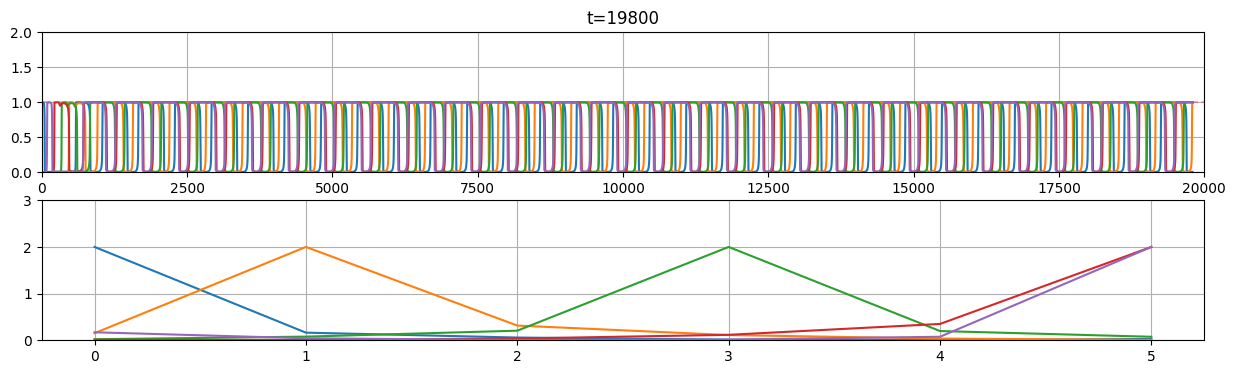

In [60]:
N = 5
T = len(X)

# neural settings
thr = 1.
u = np.ones((N, 1))*1e-8
W = np.ones((N, Nj))*1e-3
tau = 30.
lr = 0.01

# tuning
tuning = np.linspace(0, 2*np.pi, N, endpoint=False).reshape(-1, 1)

# plasticity
rule = 'hebb'
beta = 10

# record
record = np.zeros((T, N))

for t, x in enumerate(X):
        
    u += (-u)/tau + W @ x.reshape(-1, 1) + np.exp(-(np.cos(t*0.01 + tuning) - 1)**2/0.01)
    
    # activation
    u = 1 / (1 + np.exp(-6*(u - thr)))

    # plasticity
    if rule == 'hebb':
        dw = u * x
    elif rule == 'oja':
        dw = u * x - W @ (x * x)

    W += lr * dw * (np.exp(beta*W)/np.exp(beta*W).sum(axis=1, keepdims=True))

    W = W.clip(1e-3, 2e0)

    # record
    record[t] = u.flatten()

    if t % 200 == 0:
        clf()
        plt.figure(figsize=(15, 4))
        plt.subplot(211)
        plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(t), record[:t, i])
        plt.ylim((0, 2))
        plt.xlim((0, T))
        plt.grid()
        plt.title(f"{t=}")
        
        plt.subplot(212)
        #plt.imshow(W, cmap='plasma')
        for i in range(N):
            plt.plot(range(Nj), W[i])

        plt.ylim((0, 3))
        plt.grid()
        plt.pause(0.0001)

#### Lateral inhibition

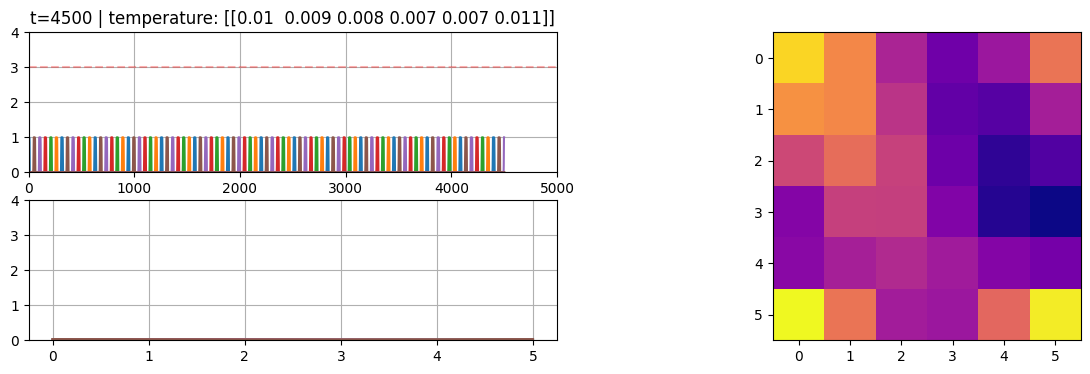

In [211]:
N = 6
T = len(X)

# neural settings
thr = 3.
u = np.ones((N, 1))*1e-8
W = np.ones((N, Nj))*1e-3
wmax = 3
tau_0 = 20.
tau = tau_0
lr = 0.01

# tuning
tuning_0 = np.linspace(0, 2*np.pi, N, endpoint=False).reshape(-1, 1)
tuning = tuning_0.copy()

# plasticity
rule = 'hebb'
beta = 10
temp = np.zeros((N, 1))

# lateral inhibition
Wr = -1 * (np.ones((N, N)) - np.eye(N))

# record
record = np.zeros((T, N))

for t, x in enumerate(X):
        
    u += (-u)/tau + W @ x.reshape(-1, 1) + thr * (1 - temp) * np.exp(
        - (np.cos(t*0.02 + tuning) - 1)**2/0.001) + Wr @ u #+ np.random.normal(0, 0.2, (N, 1))**2
    
    # activation
    u = 1 / (1 + np.exp(-7*(u - thr)))

    # time constant
    #tau += (1*u + tau_0*(1-u) - tau) / 2

    # temperature
    temp = (W.max(axis=1) / wmax).reshape(-1, 1)

    # weight decay
    W += (- W / 500) * (1 - temp)

    # plasticity
    if rule == 'hebb':
        dw = u * x
    elif rule == 'oja':
        dw = u * x - W @ (x * x)

    W += lr * dw * (np.exp(beta*W)/np.exp(beta*W).sum(axis=1, keepdims=True))

    W = W.clip(0., wmax)

    # record
    record[t] = u.flatten()

    if t % 500 == 0:
        clf()
        plt.figure(figsize=(15, 4))
        plt.subplot(221)
        plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(t), record[:t, i])
        plt.ylim((0, thr+1))
        plt.xlim((0, T))
        plt.grid()
        plt.title(f"{t=} | temperature: {np.around(temp.T, 3)}")
        
        plt.subplot(223)
        #plt.imshow(W, cmap='plasma')
        for i in range(N):
            plt.plot(range(Nj), W[i])

        plt.ylim((0, wmax+1))
        plt.grid()

        plt.subplot(122)
        plt.imshow(W, cmap='plasma')
        plt.pause(0.0001)

## Simulation II

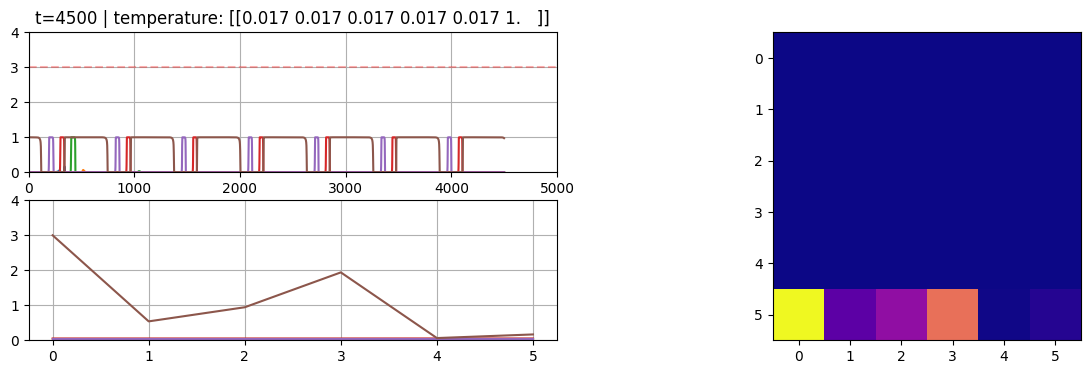

In [271]:
N = 6
T = len(X)

model = mm.RateNetwork3(N=N, Nj=Nj)

# record
record = np.zeros((T, N))

for t, x in enumerate(X):
        
    model.step(x=x.reshape(-1, 1))

    # record
    record[t] = model.u.flatten()

    if t % 500 == 0:
        clf()
        plt.figure(figsize=(15, 4))
        plt.subplot(221)
        plt.axhline(model._bias, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(t), record[:t, i])
        plt.ylim((0, thr+1))
        plt.xlim((0, T))
        plt.grid()
        plt.title(f"{t=} | temperature: {np.around(model.temp.T, 3)}")
        
        plt.subplot(223)
        #plt.imshow(W, cmap='plasma')
        for i in range(N):
            plt.plot(range(Nj), model.Wff[i])

        plt.ylim((0, model._wff_max+1))
        plt.grid()

        plt.subplot(122)
        plt.imshow(model.Wff, cmap='plasma')
        plt.pause(0.0001)

**Load individual**

In [22]:
genome = me.load_best_individual()
logger.info(f"Genome:\n{genome}")
model = mm.RateNetwork3(**genome)
logger.info(model)

2023-11-22 23:59:44 | Available files in /Users/daniekru/Research/lab/PCNN/cache:
2023-11-22 23:59:44 | 0: best_2239_r3.json
2023-11-22 23:59:44 | 1: best_2220_r3.json
2023-11-22 23:59:44 | 2: best_2238_r3.json
2023-11-22 23:59:44 | 3: best_2233_r3.json
2023-11-22 23:59:44 | 4: best_2215_r3.json
2023-11-22 23:59:44 | 5: best_ind_2238.json
2023-11-22 23:59:44 | 6: best_2342_r3.json
2023-11-22 23:59:44 | 7: best_ind_2311.json
2023-11-22 23:59:44 | 8: top_ij_1.json
2023-11-22 23:59:44 | 9: best_2227_r3.json
2023-11-22 23:59:44 | 10: best_2218_r3.json
2023-11-22 23:59:44 | 11: best_2149_r3.json
2023-11-22 23:59:44 | 12: best_2226_r3.json
2023-11-22 23:59:44 | 13: best_2132_r3.json
2023-11-22 23:59:44 | 14: best_2129_r3.json
2023-11-22 23:59:44 | 15: best_2224_r3.json
2023-11-22 23:59:44 | 16: best_2213_r3.json


Choose a file:  0


2023-11-22 23:59:50 | Best individual loaded from best_2239_r3.json in /Users/daniekru/Research/lab/PCNN/cache.
2023-11-22 23:59:50 | Genome:
{'gain': 2.0, 'bias': 3.4, 'lr': 0.64664, 'tau': 50.0, 'wff_std': 0.001, 'wff_min': 0.0, 'wff_max': 3.0, 'wff_tau': 13, 'rule': 'hebb', 'std_tuning': 0.001, 'soft_beta': 99.8, 'dt': 0.053, 'N': 6, 'Nj': 6}
2023-11-22 23:59:50 | RateNetwork3(N=6, Nj=6, rule=hebb) [aOd9N]


**Tweak the model**

In [25]:
genome['N'] = 8

model = mm.RateNetwork3(**genome)
logger.info(model)

2023-11-23 00:00:57 | RateNetwork3(N=8, Nj=6, rule=hebb) [HF2Pr]


**Settings**

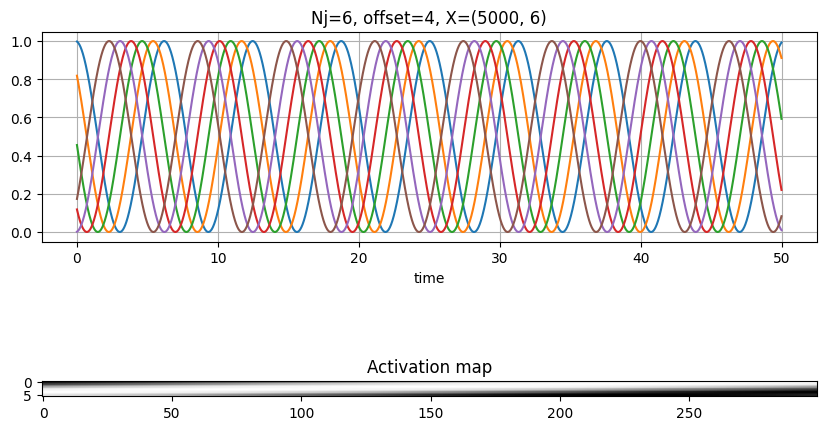

In [27]:
N = model.N
Nj = model.Nj

# data
X = make_input(Nj=Nj, plot=True)
T = len(X)

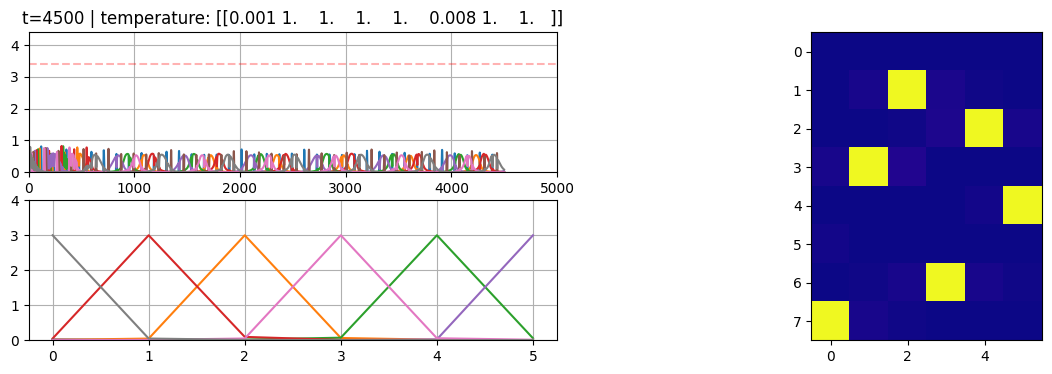

In [28]:
model.reset()

# record
record = np.zeros((T, N))

for t, x in enumerate(X):
        
    model.step(x=x.reshape(-1, 1))

    # record
    record[t] = model.u.flatten()

    if t % 500 == 0:
        clf()
        plt.figure(figsize=(15, 4))
        plt.subplot(221)
        plt.axhline(model._bias, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(t), record[:t, i])
        plt.ylim((0, model._bias+1))
        plt.xlim((0, T))
        plt.grid()
        plt.title(f"{t=} | temperature: {np.around(model.temp.T, 3)}")
        
        plt.subplot(223)
        #plt.imshow(W, cmap='plasma')
        for i in range(N):
            plt.plot(range(Nj), model.Wff[i])

        plt.ylim((0, model._wff_max+1))
        plt.grid()

        plt.subplot(122)
        plt.imshow(model.Wff, cmap='plasma')
        plt.pause(0.0001)